In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interact
from IPython.display import display
from model import *
from utils.loss_funcs import mpjpe_error
import torch
%matplotlib inline

# csv_name = 'Mixing_And_Stirring_1.csv'
# df = pd.read_csv('Mixing_And_Stirring_1.csv', header=None,skiprows=2, low_memory=False)
# # Markers start from column 378
# joints_to_idx = {}
# for idx, marker_name in enumerate(list(df.iloc[1])[378:]):
#     joints_to_idx[marker_name] = len(joints_to_idx)-1

In [2]:
model_path = '/home/portal/human_forecasting/Human_Motion_Forecasting/checkpoints/mocap_new/amass_3d_25frames_ckpt'

input_dim = 3
input_n = 10
output_n = 25
st_gcnn_dropout = 0.1
joints_to_consider = 7
n_tcnn_layers = 4
tcnn_kernel_size = [3,3]
tcnn_dropout = 0.0

model = Model(input_dim, input_n, output_n,st_gcnn_dropout, joints_to_consider,
              n_tcnn_layers, tcnn_kernel_size, tcnn_dropout).to('cpu')
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
print()

In [3]:
from utils.read_json_data import read_json, get_pose_history
json_data = read_json('./mocap_data/chopping_stirring_data/chopping_stirring_0.json')
kushal_tensor = get_pose_history(json_data, "Kushal", 25)

In [4]:
kushal_tensor.shape

torch.Size([1344, 25, 3])

In [5]:
def create_pose(ax,plots,vals,pred=True,update=False, hist = True):
    connect = [ (9, 2), (2, 16), ##torso_up
               (9, 7), (7, 13), ##leftarm
               (16, 14), (14, 20), ##rightarm
               (9, 21), (16, 23), (21, 23), ##torso_boundary
              ]

# Start and endpoints of our representation
    I   = np.array([touple[0] for touple in connect])
    J   = np.array([touple[1] for touple in connect])

    pred_color = "#af8dc3"
    gt_color = "#7fbf7b"
    hist_color = "#383838"
    if hist:
        color = hist_color
    elif pred:
        color = pred_color
    else:
        color = gt_color

    for i in np.arange( len(I) ):
        x = np.array( [vals[I[i], 0], vals[J[i], 0]] )
        z = np.array( [vals[I[i], 1], vals[J[i], 1]] )
        y = np.array( [vals[I[i], 2], vals[J[i], 2]] )
        if not update:

            if i ==0:
                plots.append(ax.plot(x, y, z, lw=2,linestyle='--' ,c=pred_color if pred else gt_color,label=['GT' if not pred else 'Pred']))
                plots[i][0].set_color(color)
            else:
                plots.append(ax.plot(x, y, z, lw=2,linestyle='--', c=color))

        elif update:
            plots[i][0].set_xdata(x)
            plots[i][0].set_ydata(y)
            plots[i][0].set_3d_properties(z)
            plots[i][0].set_color(color)
    
    return plots


def update(num,data_gt,data_pred,plots_gt,plots_pred,fig,ax):
    gt_vals=data_gt[num]
    pred_vals=data_pred[num]
    if num < input_n:
        hist = True
    else:
        hist = False
    plots_gt=create_pose(ax,plots_gt,gt_vals,pred=False,update=True, hist=hist)
    plots_pred=create_pose(ax,plots_pred,pred_vals,pred=True,update=True, hist=hist)
    
    r = 0.75
    if num == 0:
        xroot, zroot, yroot = gt_vals[0,0], gt_vals[0,1], gt_vals[0,2]
        ax.set_xlim3d([-r+xroot, r+xroot])
        ax.set_zlim3d([-r+zroot, r+zroot])
        ax.set_ylim3d([-r+yroot, r+yroot])
 
    return plots_gt,plots_pred

In [6]:
kushal_tensor.shape

torch.Size([1344, 25, 3])

In [7]:
cap_frame_length = 1344

input_n = 10
output_n = 25

joint_used = np.array([12, 16, 17, 18, 19, 20, 21])
joint_used = np.array([2, 9, 16, 7, 14, 13, 20])

losses, preds, gts = [], [], []

for start in range(input_n, cap_frame_length-input_n-output_n):
    batch = kushal_tensor[None, start:start+input_n+output_n]
    # print(batch.shape)
    batch = batch[:, :, :, :] - batch[:, 0:1, 21:22, :]
    
    sequences_train=batch[:,0:input_n,joint_used,:].permute(0,3,1,2)
    sequences_predict_gt=batch[:,:input_n+output_n,:,:]
    # print(sequences_train.shape)
    sequences_predict=model(sequences_train).permute(0,1,3,2)
    all_joints_seq=sequences_predict_gt.clone()
    all_joints_seq[:,input_n:,joint_used,:]=sequences_predict
    
    relevant_pred = all_joints_seq[:, input_n:, joint_used, :]
    relevant_gt = sequences_predict_gt[:, input_n:, joint_used, :]

    loss=mpjpe_error(relevant_pred,relevant_gt)*1000# # both must have format (batch,T,V,C)

    data_pred=torch.squeeze(all_joints_seq,0).cpu().data.numpy()
    data_gt=torch.squeeze(sequences_predict_gt,0).cpu().data.numpy()

#     if torch.isnan(loss):
#         continue
        
    preds.append(data_pred)
    gts.append(data_gt)
    losses.append(loss.item())
#     fig = plt.figure()
#     ax = Axes3D(fig)
#     vals = np.zeros((22, 3))
#     gt_plots=[]
#     pred_plots=[]

#     gt_plots=create_pose(ax,gt_plots,data_gt[0],pred=False,update=False, hist=False)
#     pred_plots=create_pose(ax,pred_plots,data_pred[0],pred=True,update=False, hist=False)

#     ax.legend(loc='lower left')
#     ax.set_title('loss in mm is: '+str(round(loss.item(),4))+' for frames= '+str(output_n))

# #     print('loss in mm is: '+str(round(loss.item(),4))+' for frames= '+str(output_n))
#     line_anim = animation.FuncAnimation(fig, update, input_n+output_n, fargs=(data_gt,data_pred,gt_plots,pred_plots
#                                                                ,fig,ax),interval=70, blit=False)

#     loss = int(round(float(loss), 0))
#     line_anim.save(f'viz_mocap/{start-input_n}_{loss}.gif')

In [9]:
np.array(losses).mean()

66.99673445175206

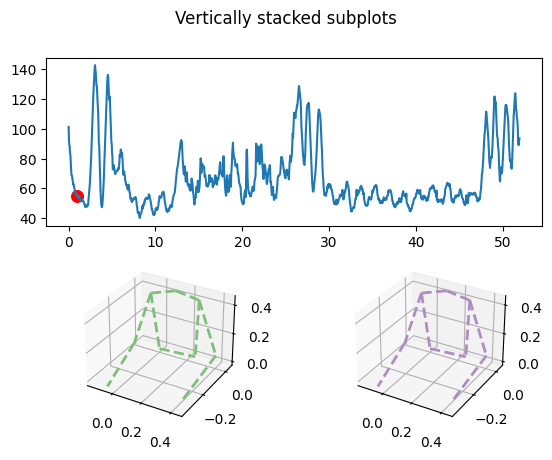

In [8]:
freq = 25
times = np.array(range(len(losses)))/freq
t = 1

fig = plt.figure()
fig.suptitle('Vertically stacked subplots')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,2,3, projection='3d')
ax3 = fig.add_subplot(2,2,4, projection='3d')

ax1.plot(times, losses)
marker = ax1.scatter(t, losses[t*freq], s=70, color='r')
# plt.xlabel('Time (in seconds)', fontsize=14)
# plt.ylabel('Mean Joint Position Error (in mm)',fontsize=14)
# marker = plt.scatter(t, losses[t*freq], marker='o', s=70, color='r')


# ax = Axes3D(fig)
vals = np.zeros((22, 3))
gt_plots=[]
pred_plots=[]

gt_plots=create_pose(ax2,gt_plots,gts[t][0],pred=False,update=False, hist=False)
pred_plots=create_pose(ax3,pred_plots,preds[t][0],pred=True,update=False, hist=False)
# plt.show()

In [16]:
len(gts[0])

35

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
%matplotlib tk

freq = 25
times = np.array(range(len(losses)))/freq
t = 1

fig = plt.figure()
fig.set_size_inches(10, 20)
fig.suptitle('Loss over Time Animation', fontsize = 30)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,2,3, projection='3d')
ax3 = fig.add_subplot(2,2,4, projection='3d')

ax1.plot(times, losses)
marker = ax1.scatter(t, losses[t*freq], s=70, color='r')
vals = np.zeros((22, 3))

gt_plots=[]
pred_plots=[]

gt_plots=create_pose(ax2,gt_plots,gts[t*freq][-1],pred=False,update=False, hist=False)
pred_plots=create_pose(ax3,pred_plots,preds[t*freq][-1],pred=True,update=False, hist=False)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(bottom=0.25)

# Make a horizontal slider to control the frequency.
axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(
    ax=axtime,
    label='Time (s)',
    valmin=0,
    valmax=35,
    valinit=1,
)


# The function to be called anytime a slider's value changes
def update(t):
#     t = int(t)
    marker.set_offsets([t, losses[int(t*freq)]])
    create_pose(ax2,gt_plots,gts[int(t*freq)][-1],pred=False,update=True, hist=False)
    create_pose(ax3,pred_plots,preds[int(t*freq)][-1],pred=True,update=True, hist=False)
    fig.canvas.draw_idle()


# register the update function with each slider
time_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    time_slider.reset()

button.on_clicked(reset)

# fig.tight_layout()

plt.show()